<a href="https://colab.research.google.com/github/mlc-ai/notebooks/blob/main/8_GPU_and_Specialized_Hardware_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ep8: GPU and Hardware Acceleration, Part 2

## Install packages 

For this course, we will use some ongoing development in tvm, which is an open-source machine learning compilation framework. We provide the following command to install a packaged version for mlc course. 

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels


## Prelude

We discussed building MLC flows for CPU and GPU environments in the past chapters. This chapter focuses on how we build conceptual programming models for specialized hardware backends.

## Preparations

To begin with, let us import the necessary dependencies.


In [2]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
from tvm import relax
import numpy as np

# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

## Hardware Specialization Trend

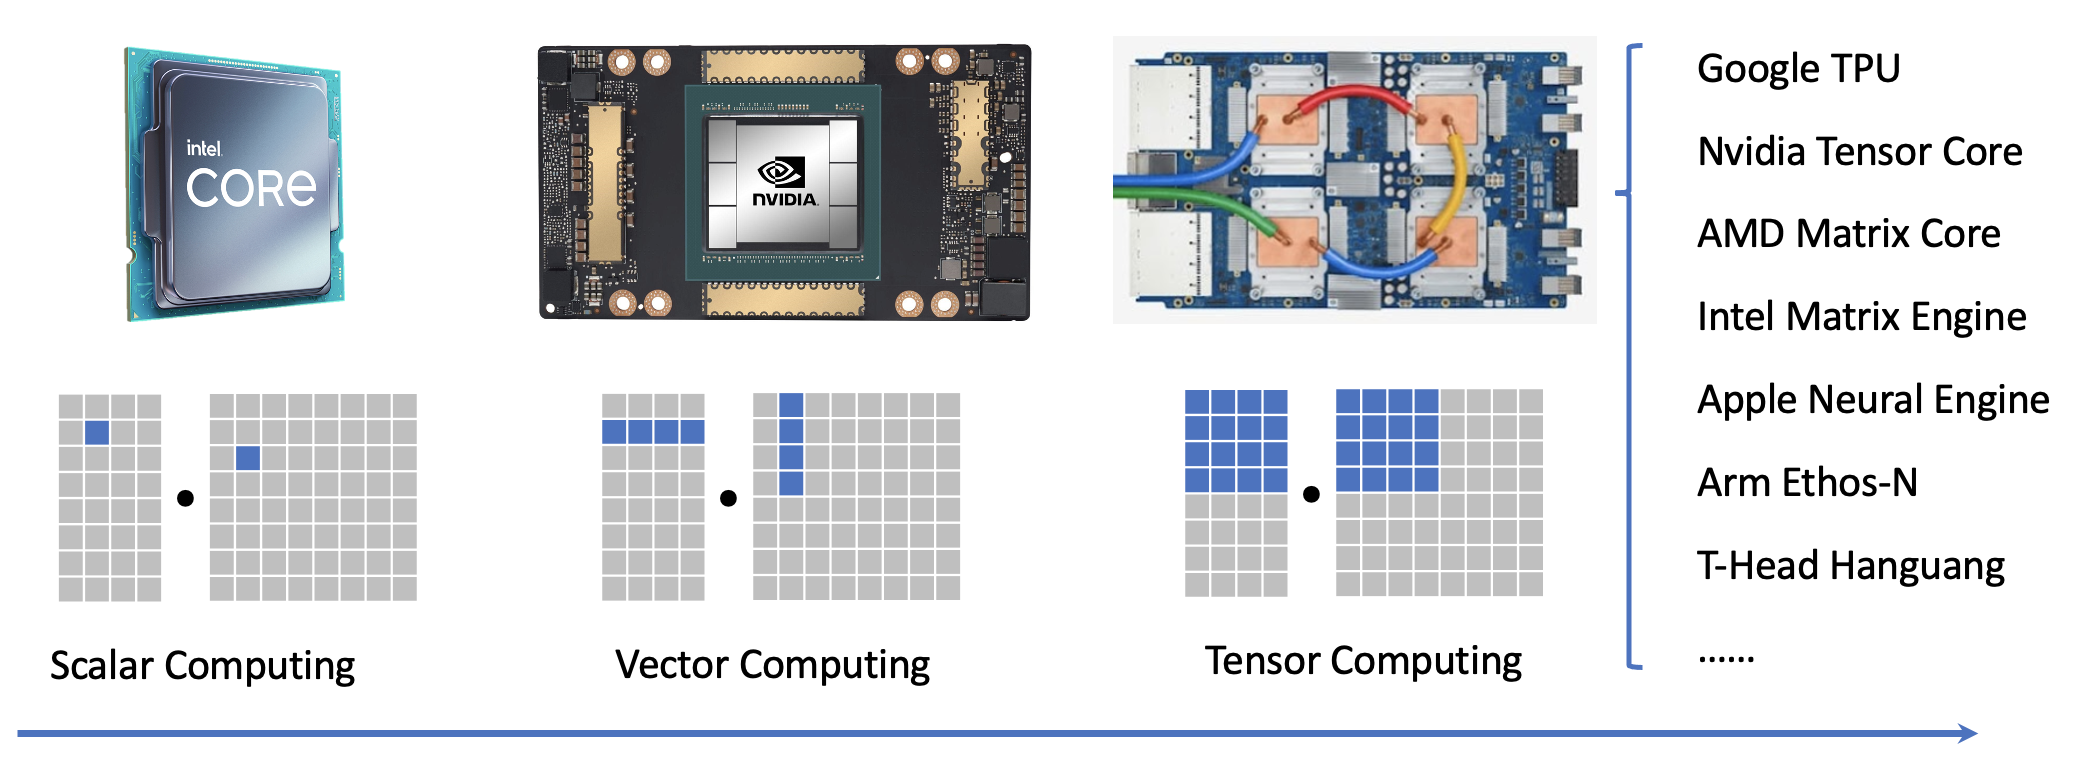

If we look at the machine learning hardware landscape, one emerging theme recently is specialization. Traditionally, we build our solutions on generic scalar processors, where we can perform operations on one floating point at a time. The vector instructions set such as AVX and ARM/Neon provide effective ways to speed up our programs but also bring some complexities to how we write the programs. 

The latest accelerators for machine learning introduced specialized units for tensor computing, with instructions for multi-dimensional data copy and matrix/tensor computations.

### Key Elements of Specialized Code

To help us better understand elements of specialized hardware programming. Let us first study the following **low-level numpy** code. While this code still runs in python, it resembles a set of possible operations that can happen in a specialized hardware backend. 

In [5]:
def accel_fill_zero(C):
    C[:] = 0

def accel_tmm_add(C, A, B):
    C[:] += A @ B.T

def accel_dma_copy(reg, dram):
    reg[:] = dram[:]

def lnumpy_tmm(A: np.ndarray, B: np.ndarray, C: np.ndarray):
    # a special accumulator memory
    C_accumulator = np.empty((16, 16), dtype="float32")
    A_reg = np.empty((16, 16), dtype="float32")
    B_reg = np.empty((16, 16), dtype="float32")

    for i in range(64):
        for j in range(64):
            accel_fill_zero(C_accumulator[:,:])
            for k in range(64):
                accel_dma_copy(A_reg[:], A[i * 16 : i * 16 + 16, k * 16 : k * 16 + 16])
                accel_dma_copy(B_reg[:], B[j * 16 : j * 16 + 16, k * 16 : k * 16 + 16])
                accel_tmm_add(C_accumulator[:,:], A_reg, B_reg)
            accel_dma_copy(C[i * 16 : i * 16 + 16, j * 16 : j * 16 + 16], C_accumulator[:,:])

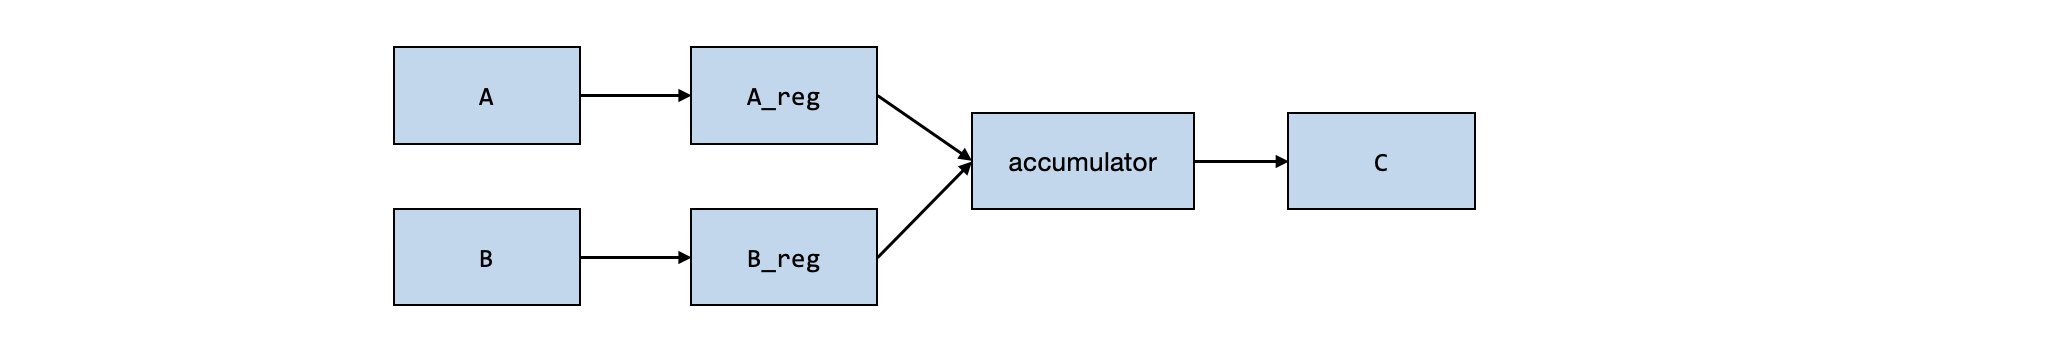

The above low-level numpy program contains the following key elements:
- The basic unit of computation is a 16x16x16 matrix multiplication (accel_tmm_add)
- accel_tmm_add takes in two inputs -- A_reg and B_reg and accumulates into an accumulator memory.
- The data copy is performed using a special function (accel_dma_copy).

In a real-world hardware backend, we usually expect `A_reg`, `B_reg`, and `C_accumulator` to map to special memory regions (or registers) in the hardware. These are called **special memory scopes**. Additionally, there is a limited set of hardware-accelerated operations we can perform on these settings. Operations such `accel_tmm_add` can be mapped to real hardware instructions or an efficient kernel function implementation provided by the vendor.

We can run the following code block to confirm the low-level numpy code runs correctly.

In [3]:
dtype = "float32"
a_np = np.random.rand(1024, 1024).astype(dtype)
b_np = np.random.rand(1024, 1024).astype(dtype)
c_tmm = a_np @ b_np.T

In [6]:
c_np = np.empty((1024, 1024), dtype="float32")
lnumpy_tmm(a_np, b_np, c_np)
np.testing.assert_allclose(c_np, c_tmm, rtol=1e-5)

### A Block with Tensorized Computation


One of our key observations is that the specialized accelerator code is not structured in the unit of scalar computations. Most of the TensorIR code we have run so far contains a block that computes a single element in the output Tensor. Many specialized accelerators run computations over regions of tensors. The block construct in TensorIR helps us to group such relevant computation.

In [7]:
@tvm.script.ir_module
class MatmulBlockModule:
    @T.prim_func
    def main(
        A: T.Buffer[(1024, 1024), "float32"],
        B: T.Buffer[(1024, 1024), "float32"],
        C: T.Buffer[(1024, 1024), "float32"],
    ) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i0, j0, k0 in T.grid(64, 64, 64):
            with T.block("tmm-16x16"):
                vi0, vj0, vk0 = T.axis.remap("SSR", [i0, j0, k0])
                with T.init():
                    for i1, j1 in T.grid(16, 16):
                        with T.block("tmm_init"):
                            vi1, vj1 = T.axis.remap("SS", [i1, j1])
                            C[vi0 * 16 + vi1, vj0 * 16 + vj1] = T.float32(0)
                
                for i1, j1, k1 in T.grid(16, 16, 16):
                    with T.block("tmm"):
                        vi1, vj1, vk1 = T.axis.remap("SSR", [i1, j1, k1])
                        C[vi0 *16 + vi1, vj0 * 16 + vj1] += \
                            A[vi0 * 16 + vi1, vk0 * 16 + vk1] * B[vj0 * 16 + vj1, vk0 * 16 + vk1]

In [8]:
MatmulBlockModule.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0, j0, k0 in T.grid(64, 64, 64):
            with T.block("tmm-16x16"):
                vi0, vj0, vk0 = T.axis.remap("SSR", [i0, j0, k0])
                T.reads(A[vi0 * 16 : vi0 * 16 + 16, vk0 * 16 : vk0 * 16 + 16], B[vj0 * 16 : vj0 * 16 + 16, vk0 * 16 : vk0 * 16 + 16])
                T.writes(C[vi0 * 16 : vi0 * 16 + 16, vj0 * 16 : vj0 * 16 + 16])
                with T.init():
                    for i1, j1 in T.grid(16, 16):
                        with T.block("tmm_init"):
                            vi1, vj1 = T.axis.remap("SS", [i1, j1])
                            T.reads()
                            T.writes(C[vi0 * 16 + vi1, vj0 * 16 + 

Let us take a closer look at the following block

```python
with T.block("tmm-16x16"):
    T.reads(A[vi0 * 16 : vi0 * 16 + 16, vk0 * 16 : vk0 * 16 + 16], B[vj0 * 16 : vj0 * 16 + 16, vk0 * 16 : vk0 * 16 + 16])
    T.writes(C[vi0 * 16 : vi0 * 16 + 16, vj0 * 16 : vj0 * 16 + 16])
    ...
```

This block reads from a 16x16 region from `A` and `B`, and writes to a 16x16 region of `C`. In this case the content of the block contains further details about a specific implementation of the subregion computations. We call this block a **tensorized block** as they contain computations that span over sub-regions of tensors.


We can run the following code to confirm that the TensorIR module produces the correct result.



In [9]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)

c_nd = tvm.nd.empty((1024, 1024), dtype="float32")

lib = tvm.build(MatmulBlockModule, target="llvm")
lib["main"](a_nd, b_nd, c_nd)
np.testing.assert_allclose(c_nd.numpy(), c_tmm, rtol=1e-5)

### Transforming Loops Around Tensorized Block

One thing that we can do here is to transform the loops surrounding the 
tensor computation block. These loop transformations can help us to reorganize the surrounding iterations to enable a space of different tensor program variants.

In [10]:
sch = tvm.tir.Schedule(MatmulBlockModule)

block_mm = sch.get_block("tmm-16x16")
i, j, k = sch.get_loops(block_mm)

i0, i1 = sch.split(i, [None, 4])

sch.reorder(i0, j, i1, k)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i0_0, j0, i0_1, k0 in T.grid(16, 64, 4, 64):
            with T.block("tmm-16x16"):
                vi0 = T.axis.spatial(64, i0_0 * 4 + i0_1)
                vj0, vk0 = T.axis.remap("SR", [j0, k0])
                T.reads(A[vi0 * 16 : vi0 * 16 + 16, vk0 * 16 : vk0 * 16 + 16], B[vj0 * 16 : vj0 * 16 + 16, vk0 * 16 : vk0 * 16 + 16])
                T.writes(C[vi0 * 16 : vi0 * 16 + 16, vj0 * 16 : vj0 * 16 + 16])
                with T.init():
                    for i1, j1 in T.grid(16, 16):
                        with T.block("tmm_init"):
                            vi1, vj1 = T.axis.remap("SS", [i1, j1])
                            T.reads()
       

### Blockization -- Creating Tensorized Blocks

In most settings, we start with loops that come with scalar computations. TensorIR provides a primitive call blockization to group subregions of a loop together to form a tensorized computation block.

In [11]:
@tvm.script.ir_module
class MatmulModule:
    @T.prim_func
    def main(
        A: T.Buffer[(1024, 1024), "float32"],
        B: T.Buffer[(1024, 1024), "float32"],
        C: T.Buffer[(1024, 1024), "float32"],
    ) -> None:
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(1024, 1024, 1024):
            with T.block("matmul"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = T.float32(0)
                C[vi, vj] += A[vi, vk] * B[vj, vk]

In [12]:
sch = tvm.tir.Schedule(MatmulModule)
i, j, k = sch.get_loops("matmul")
i, ii = sch.split(i, factors=[None, 16])
j, ji = sch.split(j, factors=[None, 16])
k, ki = sch.split(k, factors=[None, 16])
sch.reorder(i, j, k, ii, ji, ki)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0, j_0, k_0, i_1, j_1, k_1 in T.grid(64, 64, 64, 16, 16, 16):
            with T.block("matmul"):
                vi = T.axis.spatial(1024, i_0 * 16 + i_1)
                vj = T.axis.spatial(1024, j_0 * 16 + j_1)
                vk = T.axis.reduce(1024, k_0 * 16 + k_1)
                T.reads(A[vi, vk], B[vj, vk])
                T.writes(C[vi, vj])
                with T.init():
                    C[vi, vj] = T.float32(0)
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]
    



In [13]:
block_mm = sch.blockize(ii)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        for i_0, j_0, k_0 in T.grid(64, 64, 64):
            with T.block("matmul_o"):
                vi_o, vj_o, vk_o = T.axis.remap("SSR", [i_0, j_0, k_0])
                T.reads(A[vi_o * 16 : vi_o * 16 + 16, vk_o * 16 : vk_o * 16 + 16], B[vj_o * 16 : vj_o * 16 + 16, vk_o * 16 : vk_o * 16 + 16])
                T.writes(C[vi_o * 16 : vi_o * 16 + 16, vj_o * 16 : vj_o * 16 + 16])
                with T.init():
                    for i_1, j_1 in T.grid(16, 16):
                        with T.block("matmul_init"):
                            vi_i_init, vj_i_init = T.axis.remap("SS", [i_1, j_1])
                            T.reads()
                           

### Transforming TensorIR to Introduce Special Memory Scope

As we noted in the low-level NumPy code, one key element of the low-level TensorIR is the special memory scope used during the acceleration. 

We can use cache_read and write to create intermediate memory stages.



In [14]:
A_reg = sch.cache_read(block_mm, 0, storage_scope="global.A_reg")
B_reg = sch.cache_read(block_mm, 1, storage_scope="global.B_reg")
sch.compute_at(A_reg, k)
sch.compute_at(B_reg, k)

write_back_block = sch.cache_write(block_mm, 0, storage_scope="global.accumulator")
sch.reverse_compute_at(write_back_block, j)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        A_global_A_reg = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.A_reg")
        B_global_B_reg = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.B_reg")
        C_global_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.accumulator")
        for i_0, j_0 in T.grid(64, 64):
            for k_0 in T.serial(64):
                for ax0, ax1 in T.grid(16, 16):
                    with T.block("A_global.A_reg"):
                        v0 = T.axis.spatial(1024, i_0 * 16 + ax0)
                        v1 = T.axis.spatial(1024, k_0 * 16 + ax1)
                        T.reads(A[v0, v1])
                        T

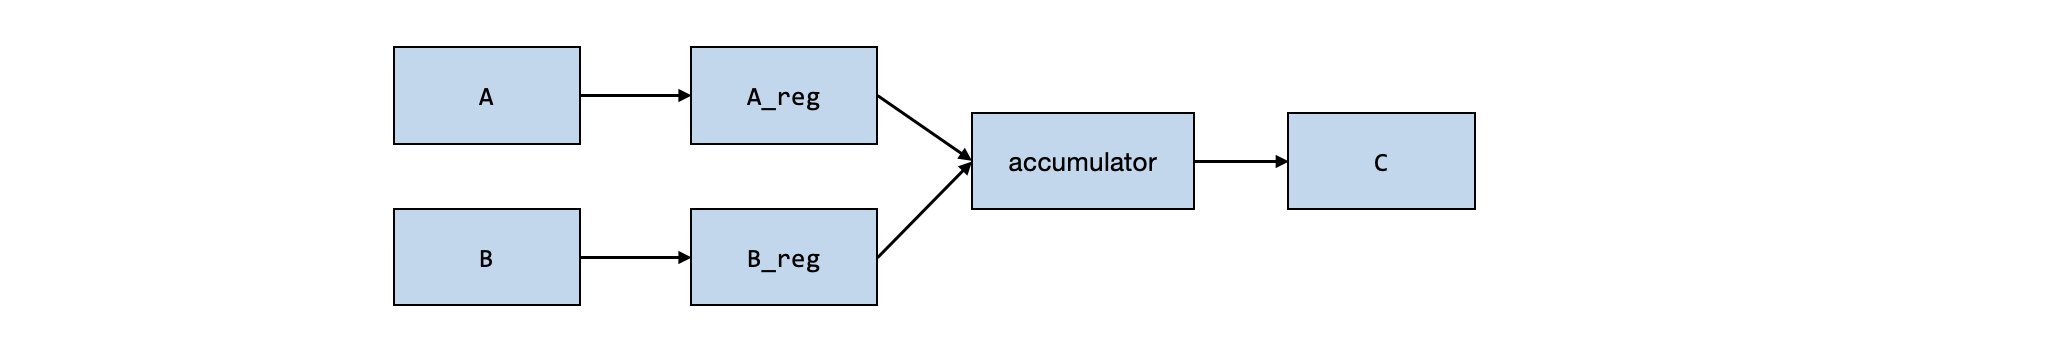

Here `global.A_reg` contains two parts. `global` indicates that all threads can globally access the memory, and `A_reg` is a **scope tag** of the memory, which provides opportunities for follow-up compilation to map it to special regions such as registers.

## Tensorization


Now we have created a set of blocks that maps to the corresponding stages of computation in the TensorIR. The remaining step is to map some of the tensorized blocks to use a specific implementation that maps to the hardware accelerated instructions. This mapping process is called **tensorization**.

To prepare for tensorization, we first register a tensor intrinsic (TensorIntrin) that contains a description of the computation and implementation. 

The system will use the description to find relevant regions that match the computation, while implementation maps the computation to accelerated hardware instructions.

In [15]:
@T.prim_func
def tmm16_desc(a: T.handle, b: T.handle, c: T.handle) -> None:
    A = T.match_buffer(a, (16, 16), "float32", offset_factor=16, scope="global.A_reg")
    B = T.match_buffer(b, (16, 16), "float32", offset_factor=16, scope="global.B_reg")
    C = T.match_buffer(c, (16, 16), "float32", offset_factor=16,  scope="global.accumulator")

    with T.block("root"):
        T.reads(C[0:16, 0:16], A[0:16, 0:16], B[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        for i, j, k in T.grid(16, 16, 16):
            with T.block(""):
                vii, vjj, vkk = T.axis.remap("SSR", [i, j, k])
                C[vii, vjj] = C[vii, vjj] + A[vii, vkk] * B[vjj, vkk]


@T.prim_func
def tmm16_impl(a: T.handle, b: T.handle, c: T.handle) -> None:
    sa = T.var("int32")
    sb = T.var("int32")
    sc = T.var("int32")
    A = T.match_buffer(a, (16, 16), "float32", offset_factor=16, strides=[sa, 1], scope="global.A_reg")
    B = T.match_buffer(b, (16, 16), "float32", offset_factor=16, strides=[sb, 1], scope="global.B_reg")
    C = T.match_buffer(c, (16, 16), "float32", offset_factor=16, strides=[sc, 1], scope="global.accumulator")

    with T.block("root"):
        T.reads(C[0:16, 0:16], A[0:16, 0:16], B[0:16, 0:16])
        T.writes(C[0:16, 0:16])
        T.evaluate(
            T.call_extern(
                "tmm16",
                C.access_ptr("w"),
                A.access_ptr("r"),
                B.access_ptr("r"),
                sa,
                sb,
                sc,
                dtype="int32",
            )
        )

tvm.tir.TensorIntrin.register("tmm16", tmm16_desc, tmm16_impl)


As a preparation step, we first decompose the reduction into an initialization block and an update step. 

In [16]:
sch.decompose_reduction(block_mm, k)
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        A_global_A_reg = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.A_reg")
        B_global_B_reg = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.B_reg")
        C_global_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.accumulator")
        for i_0, j_0 in T.grid(64, 64):
            with T.block("matmul_o_init"):
                vi_o, vj_o = T.axis.remap("SS", [i_0, j_0])
                T.reads()
                T.writes(C_global_accumulator[vi_o * 16 : vi_o * 16 + 16, vj_o * 16 : vj_o * 16 + 16])
                for i_1, j_1 in T.grid(16, 16):
                    with T.block("matmul_init"):
        

Then we can call tensorize, to map the `block_mm` (which corresponds to the `matmul_o_update` block) to use the implementation of `tmm16`.

In [17]:
sch.tensorize(block_mm, "tmm16")

In [18]:
sch.mod.show()

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(1024, 1024), "float32"], B: T.Buffer[(1024, 1024), "float32"], C: T.Buffer[(1024, 1024), "float32"]) -> None:
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        sa = T.var("int32")
        sb = T.var("int32")
        sc = T.var("int32")
        # body
        # with T.block("root")
        A_global_A_reg = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.A_reg")
        B_global_B_reg = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.B_reg")
        C_global_accumulator = T.alloc_buffer([1024, 1024], dtype="float32", scope="global.accumulator")
        for i_0, j_0 in T.grid(64, 64):
            with T.block("matmul_o_init"):
                vi_o, vj_o = T.axis.remap("SS", [i_0, j_0])
                T.reads()
                T.writes(C_global_accumulator[vi_o * 16 : vi_o * 16 + 16, vj_o * 16 : vj_o * 16 + 16])
                for i

Here we use `T.call_extern` to call into an external function inside the environment. The downstream compilation step can easily map the implementation to an instruction that implements the operation. 

Alternatively, we can map tmm16 to a micro-kernel that implements this tensorized computation. The following code shows the how to do that through an extern "C" code (which allows further embedding of inline assembly if necessary).

In [19]:
def tmm_kernel():
    cc_code = """
      extern "C" int tmm16(float *cc, float *aa, float *bb, int stride_a, int stride_b, int stride_c) {
        for (int i = 0; i < 16; ++i) {
            for (int j = 0; j < 16; ++j) {
                for (int k = 0; k < 16; ++k) {
                    cc[i * stride_c + j] += aa[i * stride_a + k] * bb[j * stride_b + k];
                }
            }
        }
        return 0;
      }
    """
    from tvm.contrib import utils, clang

    temp = utils.tempdir()
    ll_path = temp.relpath("temp.ll")
    # Create LLVM ir from c source code
    ll_code = clang.create_llvm(cc_code, output=ll_path)
    return ll_code

sch.annotate(i, "pragma_import_llvm", tmm_kernel())

We can then go and execute the following code-block, which redirects the tensorized computation to the custom defined `tmm_kernel`.

In [20]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)

c_nd = tvm.nd.empty((1024, 1024), dtype="float32")

lib = tvm.build(sch.mod, target="llvm")
lib["main"](a_nd, b_nd, c_nd)
np.testing.assert_allclose(c_nd.numpy(), c_tmm, rtol=1e-5)

## Discussions

This section covers a set of key elements of specialized hardware support. One of the key constructs here is the tensorized block and computation alongside tensor subregions. TensorIR also contains additional properties that build on top of the foundational elements:

- Layout constraints in the specialized memory.
- Interaction with thread hierarchies.

We don't have enough time to cover these in one lecture, but we will add optional readings on some of the additional content.

## Summary

- Overall trend of Hardware Specialization toward tensorized computation.
- TensorIR transformations with tensorized blocks.
- Tensorization: the process of mapping block of loop computations to specialized implementations.
